In [1]:
# 1. Imports
# ---------------------------
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, Trainer, TrainingArguments
import numpy as np

d:\anconda\envs\segformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = SegmentationDataset(r"D:\cellula\task_2\data\images_png", r"D:\cellula\task_2\data\labels", transform=transform)

In [20]:
import os
from sklearn.model_selection import train_test_split

# List all images and masks
images = sorted(os.listdir(r"D:\cellula\task_2\data\images_png"))
masks = sorted(os.listdir(r"D:\cellula\task_2\data\labels"))

# Split into train and validation
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Optional: print dataset sizes
print(f"Training samples: {len(train_imgs)}")
print(f"Validation samples: {len(val_imgs)}")


Training samples: 244
Validation samples: 62


In [21]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, images_list, masks_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = images_list
        self.masks = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Example transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = SegmentationDataset(r"D:\cellula\task_2\data\images_png", r"D:\cellula\task_2\data\labels", train_imgs, train_masks, transform)
val_dataset = SegmentationDataset(r"D:\cellula\task_2\data\images_png", r"D:\cellula\task_2\data\labels", val_imgs, val_masks, transform)


In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [23]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


In [24]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch

model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

# Load feature extractor (handles image preprocessing)
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# Load pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 76181c51-9d4c-4b2e-851a-c58cbe8e7ff1)')' thrown while requesting HEAD https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
d:\anconda\envs\segformer\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
d:\anconda\envs\segformer\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


In [ ]:
#from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()  # for segmentation masks

for epoch in range(5):  # example: 5 epochs
    model.train()
    for pixel_values, masks in train_loader:
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        if masks.ndim == 4:
            masks = masks.squeeze(1)  # shape: [batch, H, W]
 

        outputs = model(pixel_values=pixel_values).logits
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


KeyboardInterrupt: 

In [ ]:
for pixel_values, masks in train_loader:
    pixel_values = pixel_values.to(device)
    masks = masks.to(device)

    # Remove channel if exists
    if masks.ndim == 4:
        masks = masks.squeeze(1)  # [batch, H, W]

    # Forward pass
    outputs = model(pixel_values=pixel_values).logits  # [B, C, H_out, W_out]

    # Resize masks to match output
    masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

    loss = criterion(outputs, masks_resized)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [45]:
from torch import nn, optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()  # for segmentation masks

for epoch in range(25):  # example: 5 epochs
    model.train()
    for pixel_values, masks in train_loader:
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        if masks.ndim == 4:
            masks = masks.squeeze(1)  # shape: [batch, H, W]

            # Forward pass
        outputs = model(pixel_values=pixel_values).logits  # [B, C, H_out, W_out]

        masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks_resized)

       

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


Epoch 1 - Loss: 1.0233
Epoch 2 - Loss: 0.2520
Epoch 3 - Loss: 0.3819
Epoch 4 - Loss: 0.4989
Epoch 5 - Loss: 0.4939
Epoch 6 - Loss: 0.3260
Epoch 7 - Loss: 0.1738
Epoch 8 - Loss: 0.3083
Epoch 9 - Loss: 0.4225
Epoch 10 - Loss: 0.1439
Epoch 11 - Loss: 0.2189
Epoch 12 - Loss: 0.3472
Epoch 13 - Loss: 0.3221
Epoch 14 - Loss: 0.3825
Epoch 15 - Loss: 0.2020
Epoch 16 - Loss: 0.1293
Epoch 17 - Loss: 0.1646
Epoch 18 - Loss: 0.1835
Epoch 19 - Loss: 0.2257
Epoch 20 - Loss: 0.5247
Epoch 21 - Loss: 0.2409
Epoch 22 - Loss: 0.1454
Epoch 23 - Loss: 0.1398
Epoch 24 - Loss: 0.1636
Epoch 25 - Loss: 0.2370


In [46]:
def dice_score(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)


In [47]:
torch.save(model.state_dict(), "segformer_finetuned.pth")

In [48]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    outputs = model(pixel_values=imgs).logits
    preds = torch.argmax(outputs, dim=1).cpu().numpy()


In [49]:
class SegmentationHFDataset(Dataset):
    def __init__(self, image_list, mask_list, image_dir, mask_dir, feature_extractor):
        self.image_list = image_list
        self.mask_list = mask_list
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = f"{self.image_dir}/{self.image_list[idx]}"
        mask_path = f"{self.mask_dir}/{self.mask_list[idx]}"

        from PIL import Image
        import numpy as np
        import torch

        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.int64)  # class indices

        # Preprocess image
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)  # remove batch dim

        # Convert mask to tensor
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return pixel_values, mask_tensor


In [50]:
train_dataset = SegmentationHFDataset(train_imgs, train_masks, r"data\images_png", r"D:\cellula\task_2\data\labels", feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [51]:
images, masks = next(iter(train_loader))
print(type(images), images.shape)  # should be torch.Tensor


<class 'torch.Tensor'> torch.Size([4, 3, 512, 512])


In [52]:
images_np = images.permute(0, 2, 3, 1).cpu().numpy()
masks_np = masks.cpu().numpy()
outputs = model(pixel_values=images.to(device)).logits
preds_np = torch.argmax(outputs, dim=1).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.465708].


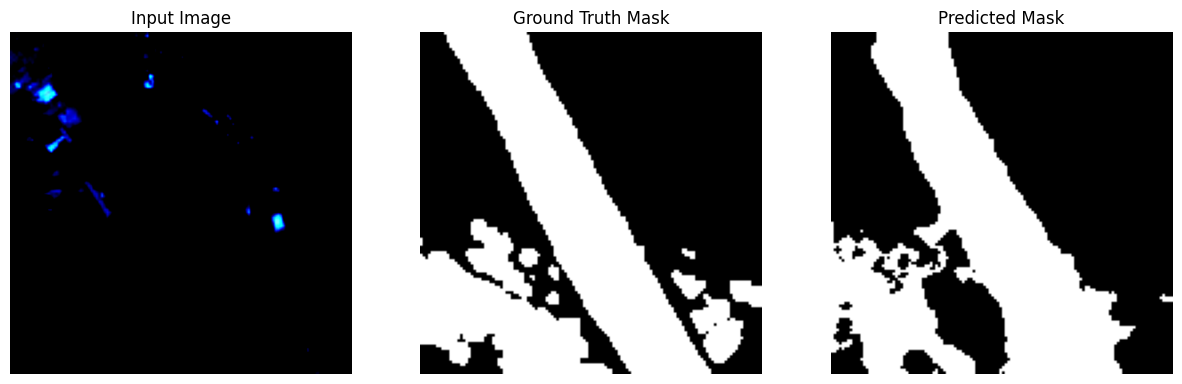

In [53]:
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    # Assume images and masks are already tensors
    images = images.to(device)
    masks = masks.to(device)

    # Forward pass
    outputs = model(pixel_values=images).logits
    preds = torch.argmax(outputs, dim=1)  # [B, H, W]

    # Convert to NumPy for plotting
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    masks_np = masks.cpu().numpy()
    preds_np = preds.cpu().numpy()

# Visualize first image in batch
batch_idx = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(images_np[batch_idx])
axs[0].set_title("Input Image")
axs[0].axis("off")

axs[1].imshow(masks_np[batch_idx], cmap="gray")
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

axs[2].imshow(preds_np[batch_idx], cmap="gray")
axs[2].set_title("Predicted Mask")
axs[2].axis("off")

plt.show()
